In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

test = pd.read_csv('/content/drive/MyDrive/itmo/test_x.csv')
train = pd.read_csv('/content/drive/MyDrive/itmo/train.csv')

# Преобразование данных

In [10]:
train.head()

,user_id,org_id,rating,ts,user_city,org_city,average_bill,rating_org,rubrics,food_delivery,...,call_button,wheelchair_accessible,table_games,vinotheque,cakes_for_different_occasions,accepted_credit_cards,kalyan,teahouse,bread_from_tandoor,handmade_goods
0,12182789761588196310,11946401375069641937,4.0,677,msk,msk,1500.0,3.883212,Ресторан,1,...,0,0,0,0,0,0,0,0,0,0
1,2796544982129273287,5545859981678495568,5.0,577,msk,msk,1000.0,4.495379,Ресторан,1,...,0,0,0,0,0,0,0,0,0,0
2,10546824832088319728,3451485117888180206,4.0,716,msk,msk,500.0,4.576063,Кафе,1,...,0,0,0,0,0,0,0,0,0,0
3,9967742981458207920,9490041040735762889,3.0,639,spb,spb,1000.0,3.775701,Кафе,1,...,0,0,0,0,0,0,0,0,0,0
4,11046819495825038093,5234254278902729372,5.0,669,msk,msk,500.0,4.187500,Пиццерия,1,...,0,1,0,0,0,0,0,0,0,0


### 1) Пропуски

Пропуски есть только в столбце average_bill, зато их целых 39%.

Что с ними делать - сходу непонятно :(

Заменим на среднее, чтож...

In [11]:
train.columns[train.isna().any()].tolist()

['average_bill']

In [12]:
train.average_bill.isna().sum() / train.average_bill.size

0.38599905399013446

mean = 1075.891972795105 500.0


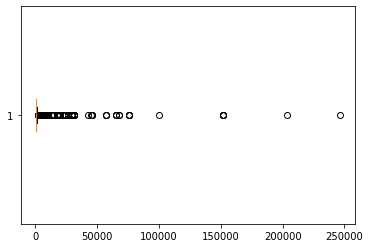

In [13]:
print("mean =", train.average_bill.mean(), train.average_bill.median())
plt.boxplot(train.dropna().average_bill, vert=False)
plt.show()

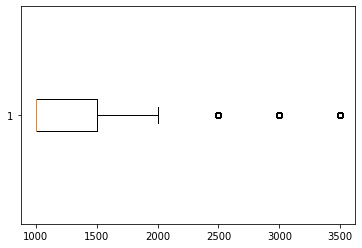

In [14]:
from scipy import stats

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.01)
    q3 = df_in[col_name].quantile(0.99)
    df_out = df_in.loc[(df_in[col_name] < q3) & (df_in[col_name] > q1)]
    return df_out

plt.boxplot(remove_outlier(train, "average_bill").average_bill, vert=False)
plt.show()

### 2) Нечисленные признаки

Заметим, что почти все признаки являются численными.

Рассмотрим нечисленные признаки:

1) поле user_city принимает только 2 возможных значения - msk и spb, для удобства дальнейшей работы создадим новую bool колонку user_from_msk

2) с полем org_city поступим аналогично

NB: возможно, стоит создать колонку (user_from_msk && org_from_msk)

3) поле rubrics: для самых часто-встречаемых признаков выделим отдельные булевские колонки

In [15]:
train.select_dtypes(exclude=[np.number])[:5]

,user_city,org_city,rubrics
0,msk,msk,Ресторан
1,msk,msk,Ресторан
2,msk,msk,Кафе
3,spb,spb,Кафе
4,msk,msk,Пиццерия


In [16]:
print("user city =", train.user_city.unique())
print("org city =", train.org_city.unique())
print("rubrics =", train.rubrics.unique())

user city = ['msk' 'spb']
org city = ['msk' 'spb']
rubrics = ['Ресторан' 'Кафе' 'Пиццерия' 'Быстрое питание' 'Бар, паб' 'Кофейня'
 'Кофе с собой' 'Булочная, пекарня' 'Кондитерская' 'Суши-бар' 'Кальян-бар'
 'Спортбар' 'Столовая' 'Бар безалкогольных напитков']


In [17]:
most_popular_rubrics = list(train.rubrics.value_counts().keys()[:7])

### 3) Нормализация

### Итоговая функция трансформации датасета

In [18]:
from sklearn import preprocessing

def add_columns(df):
  df['user_from_msk'] = df.apply(lambda row: 1 if row.user_city == 'msk' else 0, axis=1)
  df['org_from_msk'] = df.apply(lambda row: 1 if row.org_city == 'msk' else 0, axis=1)
  df['from_the_same_city'] = df.apply(lambda row: 1 
                                            if row.user_from_msk + row.org_from_msk != 1 
                                            else 0, axis=1)
  
  df['low_price'] = df.apply(lambda row: 1 if row.average_bill < 500 else 0, axis=1)
  df['middle_price'] = df.apply(lambda row: 1 if row.average_bill >= 500 and row.average_bill < 1000 else 0, axis=1)
  df['height_price'] = df.apply(lambda row: 1 if row.average_bill >= 1000 and row.average_bill < 1500 else 0, axis=1)

  for rbr in most_popular_rubrics:
    df[rbr] = df.apply(lambda row: 1 if row.rubrics == rbr else 0, axis=1)

def transform_df(df_old):
  df = df_old.copy()
  df.average_bill.fillna(df.average_bill.mean(), inplace=True)
  add_columns(df)

  df.drop(columns=['user_city', 'org_city', 'rubrics', 'user_id', 'org_id'], inplace=True)

  # нормализация
  for col_name in ['rating', 'average_bill', 'ts']:
    max_value = df[col_name].max()
    min_value = df[col_name].min()
    df[col_name] = (df[col_name] - min_value) / (max_value - min_value)

  return df

In [19]:
train_transformed = transform_df(train)

test_transformed = transform_df(test)
train_transformed.head()

,rating,ts,average_bill,rating_org,food_delivery,breakfast,takeaway,summer_terrace,wi_fi,business_lunch,...,low_price,middle_price,height_price,Ресторан,Кафе,Быстрое питание,"Бар, паб",Кофейня,Кондитерская,Пиццерия
0,0.75,0.556743,0.004065,3.883212,1,1,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0
1,1.00,0.474507,0.002033,4.495379,1,0,1,1,1,1,...,0,0,1,1,0,0,0,0,0,0
2,0.75,0.588816,0.000000,4.576063,1,1,1,1,1,1,...,0,1,0,0,1,0,0,0,0,0
3,0.50,0.525493,0.002033,3.775701,1,1,1,1,1,1,...,0,0,1,0,1,0,0,0,0,0
4,1.00,0.550164,0.000000,4.187500,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,1


# Корреляция

Будем передавать в алгоритм только признаки, коэффициент корреляции rating_org с которыми больше 5%.

In [20]:
train = train_transformed
test = test_transformed

corr = train.corr()['rating_org'].sort_values(ascending=False)[1:]
print(corr)

significant_attr_names = list(key for (key, value) in corr.items() if abs(value) >= 0.05)
print(significant_attr_names)
train_filtered = train[significant_attr_names]

test_filtered = test[significant_attr_names]

rating                    0.269386
cafe                      0.181062
toilet_for_disabled       0.173958
parking_disabled          0.167170
payment_by_credit_card    0.154419
                            ...   
free_delivery            -0.072332
middle_price             -0.102564
food_delivery            -0.105047
Быстрое питание          -0.183910
low_price                      NaN
Name: rating_org, Length: 79, dtype: float64
['rating', 'cafe', 'toilet_for_disabled', 'parking_disabled', 'payment_by_credit_card', 'automatic_door', 'wheelchair_access', 'car_park', 'craft_beer', 'gift_certificate', 'Кофейня', 'sports_broadcasts', 'privilege_tickets', 'projector', 'wi_fi', 'Ресторан', 'food_product_delivery', 'karaoke', 'farm_products', 'organic_food', 'table_games', 'promotions', 'takeaway', 'elevator_wheelchair_accessible', 'Бар, паб', 'music', 'from_the_same_city', 'minimum_order', 'self_service_kiosks', 'free_delivery', 'middle_price', 'food_delivery', 'Быстрое питание']


#kNN

In [21]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [22]:
# Y_train = train.rating_org
# X_train = train_filtered

test_size = 0.2

Y_train = train_test_split(train, test_size = test_size)[0].rating_org
X_train = train_test_split(train_filtered, test_size = test_size)[0]

In [23]:
# подберем наилучшее значение n_neighbors
# g = GridSearchCV(KNeighborsRegressor(), { "n_neighbors" : [5, 7, 11, 15, 17, 16, 22] })
# g.best_params_
# {'n_neighbors': 22}

g = KNeighborsRegressor(n_neighbors=22)
g.fit(X_train.values, Y_train.values)

KNeighborsRegressor(n_neighbors=22)

In [24]:
train_predictions = g.predict(train_test_split(train_filtered, test_size = test_size)[1])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [32]:
_, test_ = train_test_split(train, test_size = test_size)
mean_absolute_percentage_error(train_predictions, test_.rating_org)

0.05285312475730688

### Предсказания для test

In [26]:
reg = g
final_pred = reg.predict(test_filtered)

result = pd.DataFrame({'id': test_filtered.index, 'rating_org': final_pred})
result.set_index('id', inplace = True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [27]:
import os 
version = 5
dir = 'submission' + str(version)
os.makedirs(dir, exist_ok=True)  
print(len(result))
result.to_csv(dir + '/submission' + str(version) + ".csv") 

24665
